In [1]:
import numpy as np
from scipy.io import loadmat
import torch
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import Dataset

class MatDataset(Dataset):
    def __init__(self, mat_files):
        self.mat_files = mat_files
        # Determine the max_length once during initialization
        self.max_length = self.determine_max_length()

    def determine_max_length(self):
        max_length = 0
        for file in self.mat_files:
            mat_data = loadmat(file, squeeze_me=True, struct_as_record=False)
            length = len(mat_data['id'])
            if length > max_length:
                max_length = length
        return max_length

    def __len__(self):
        return len(self.mat_files)

    def __getitem__(self, idx):
        # Load one .mat file
        file = self.mat_files[idx]
        mat_data = loadmat(file, squeeze_me=True, struct_as_record=False)
            
        # Extract input and output variables and reshape them
        inputs = np.hstack([mat_data[var].reshape(-1, 1) for var in ['id', 'id_ref', 'IntErr_Id', 'IntErr_Iq', 'iq', 'iq_ref']])
        outputs = np.hstack([mat_data[var].reshape(-1, 1) for var in ['v_md', 'v_mq']])
            
        # Pad the sequences to self.max_length
        inputs = pad_sequences(inputs, maxlen=self.max_length, padding='post')
        outputs = pad_sequences(outputs, maxlen=self.max_length, padding='post')
        
        # Convert numpy arrays to torch tensors
        inputs = torch.tensor(inputs, dtype=torch.float32)
        outputs = torch.tensor(outputs, dtype=torch.float32)
        
        return inputs, outputs


In [3]:
import os

data_dir = "E:/Data"  # Directory containing all .mat files

all_mat_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.mat')]

np.random.shuffle(all_mat_files)  # Shuffle the list of .mat files

# divide the data into train, test and validation sets
# 70% percent of the data is used for training, 15% for testing and 15% for validation

num_files = len(all_mat_files)
train_files = all_mat_files[:int(0.7 * num_files)] 
test_files = all_mat_files[int(0.7 * num_files):int(0.85 * num_files)]
val_files = all_mat_files[int(0.85 * num_files):]

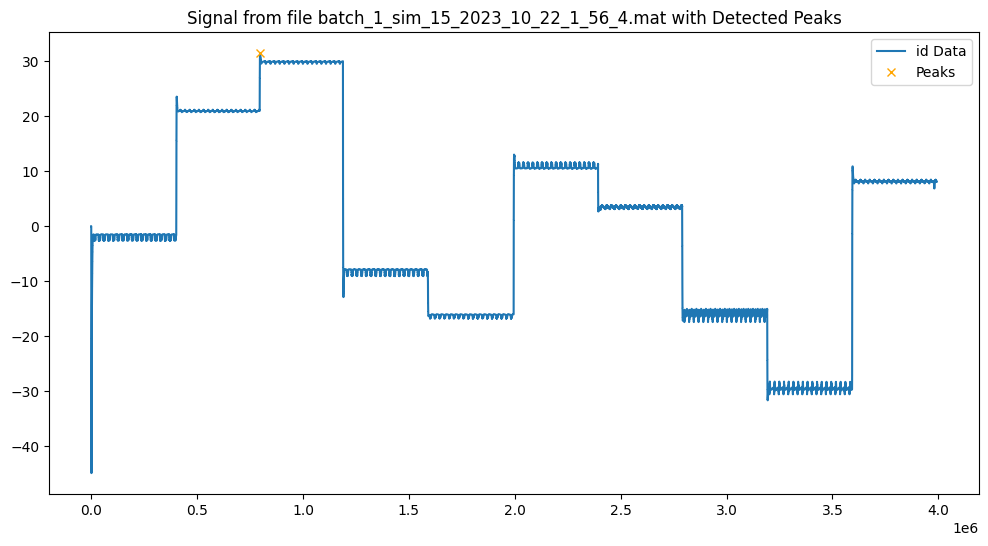

Total number of peaks: 1


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import find_peaks
import random
import os

# Get a list of all .mat files
data_dir = "E:/Data"
all_mat_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.mat')]

# Select a random .mat file
random_file = random.choice(all_mat_files)

# Load the .mat file
mat_data = loadmat(random_file, squeeze_me=True, struct_as_record=False)

# Extract 'id' variable from the loaded .mat file
id_data = mat_data['id']

# Dynamically determine distance and height for peak detection
mean_signal = np.mean(id_data)
std_signal = np.std(id_data)
height_threshold = mean_signal + std_signal

# The distance is inversely proportional to the average absolute derivative
avg_derivative = np.mean(np.abs(np.diff(id_data)))
distance_threshold = int(1 / avg_derivative * 1000)  # scaled by 1000 for better granularity

# Detect peaks
peak_indices, _ = find_peaks(id_data, distance=distance_threshold, height=height_threshold)

# Count the total number of peaks
number_of_peaks = len(peak_indices)

# Plot the 'id' data with detected peaks
plt.figure(figsize=(12, 6))
plt.plot(id_data, label='id Data')
plt.plot(peak_indices, id_data[peak_indices], "x", label='Peaks', color='orange')
plt.title(f'Signal from file {os.path.basename(random_file)} with Detected Peaks')
plt.legend()
plt.show()

# Print the total number of peaks
print("Total number of peaks:", number_of_peaks)


In [25]:
# Definir el rango de interés
start_index = 4000
end_index = 500000
id_data_segment = id_data[start_index:end_index]

# Suavizar la señal para reducir el ruido
window_size = 10000  # Tamaño de la ventana, más grande para un suavizado más fuerte
id_data_smoothed = np.convolve(id_data_segment, np.ones(window_size)/window_size, mode='same')

# Encuentra los valores constantes que representan los "floors"
# Supongamos que un 'floor' es un segmento donde la señal es relativamente constante
threshold = std_signal / 5
floors_values = []

min_length = 1000  # Número mínimo de puntos consecutivos para considerar un 'floor'

i = 0
while i < (len(id_data_smoothed) - min_length):
    # Tomar un segmento de la señal
    segment = id_data_smoothed[i:i + min_length]
    if np.max(segment) - np.min(segment) < threshold:
        # Si la variación dentro del segmento es menor que el umbral, es un 'floor'
        floors_values.append(np.mean(segment))
        # Salta al final del segmento para comenzar a buscar el siguiente 'floor'
        i += min_length
    else:
        # Si no es un 'floor', avanza un punto
        i += 1

# Eliminar duplicados y cercanos - esto asume que los valores del piso no cambiarán rápidamente
unique_floors = np.unique(floors_values)

# Mostrar los valores de los "floors" detectados
for floor in unique_floors:
    print(f"Detected floor value: {floor}")

Detected floor value: -2.7728958114617646
Detected floor value: -2.5617026410947283
Detected floor value: -2.556234637148201
Detected floor value: -2.400497909770296
Detected floor value: -2.2513594707387368
Detected floor value: -2.1140074512211497
Detected floor value: -2.112983130194364
Detected floor value: -2.1126058503275207
Detected floor value: -2.111955483656011
Detected floor value: -2.1119115043880967
Detected floor value: -2.111693103070026
Detected floor value: -2.1113338306337024
Detected floor value: -2.111185658915143
Detected floor value: -2.1104327002382237
Detected floor value: -2.1103578393237856
Detected floor value: -2.110047098465577
Detected floor value: -2.109772732667012
Detected floor value: -2.10933583558816
Detected floor value: -2.108680731152645
Detected floor value: -2.107739170357919
Detected floor value: -2.106765197590087
Detected floor value: -2.1066880620416333
Detected floor value: -2.105911359632648
Detected floor value: -2.1045258372260327
Detect

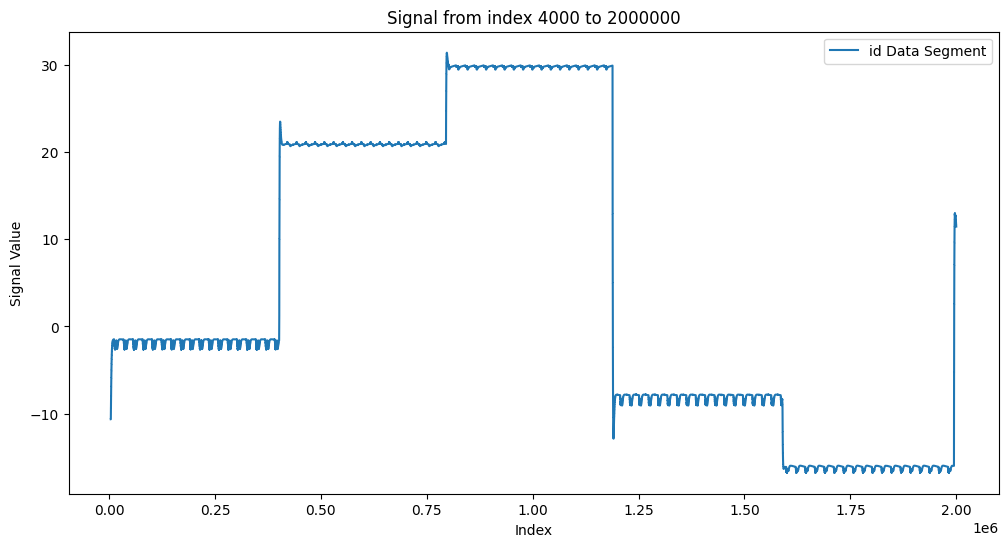

In [32]:
# Definir el rango de interés para graficar
start_index = 4000
end_index = 2000000

# Extraer el segmento de interés de la señal
id_data_segment = id_data[start_index:end_index]

# Crear la figura y el eje para la gráfica
plt.figure(figsize=(12, 6))

# Graficar el segmento de interés
plt.plot(range(start_index, end_index), id_data_segment, label='id Data Segment')

# Configuraciones de la gráfica
plt.title(f'Signal from index {start_index} to {end_index}')
plt.xlabel('Index')
plt.ylabel('Signal Value')
plt.legend()
plt.show()

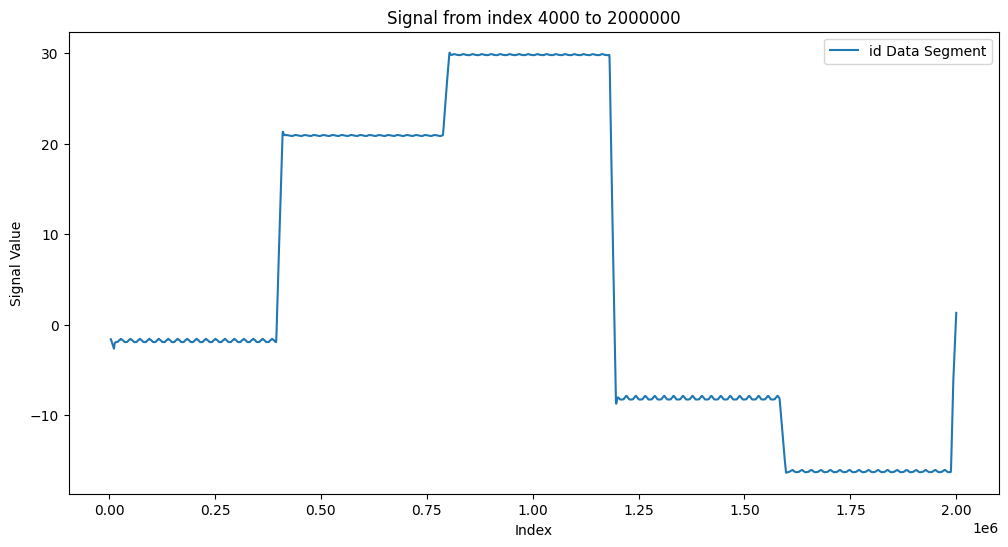

In [33]:
# Definir el rango de interés para graficar
start_index = 4000
end_index = 2000000

# Extraer el segmento de interés de la señal
id_data_segment = id_data[start_index:end_index]

# Suavizar la señal para reducir el ruido
window_size = 15000  # Tamaño de la ventana, más grande para un suavizado más fuerte
id_data_smoothed = np.convolve(id_data_segment, np.ones(window_size)/window_size, mode='same')

# Crear la figura y el eje para la gráfica
plt.figure(figsize=(12, 6))

# Graficar el segmento de interés
plt.plot(range(start_index, end_index), id_data_smoothed, label='id Data Segment')

# Configuraciones de la gráfica
plt.title(f'Signal from index {start_index} to {end_index}')
plt.xlabel('Index')
plt.ylabel('Signal Value')
plt.legend()
plt.show()